# P03_02_LSTM


In [1]:
section_fig_main_title = 'P03_02_LSTM_'

In [2]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
import sys
# print(sys.executable)

In [4]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install matplotlib

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [34]:
%config InlineBackend.figure_format = 'retina'

In [35]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

### Read data

In [7]:
csv_path = "../Data/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

In [8]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Base on P02_03 EDA analysis I choose following columns for modeling.

The essential parameters to be considered for modeling are as follows.

```
'p (mbar)','Tpot (K)','Tdew (degC)','VPact (mbar)','sh (g/kg)','H2OC (mmol/mol)','rho (g/m**3)','wd (deg)'
```

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [9]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

import math
from sklearn.metrics import mean_squared_error

In [10]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='test')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('Prediction')
    plt.xlabel('Date')
    plt.ylabel('temp')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [32]:
train_start = '2009-01-01 00:10:00'
train_end = '2009-05-19 21:20:00'

test_start = '2009-05-19 21:30:00'
test_end = '2009-05-24 21:20:00'

In [39]:
training_set = df['T (degC)'][train_start:train_end]
test_set = df['T (degC)'][test_start:test_end]

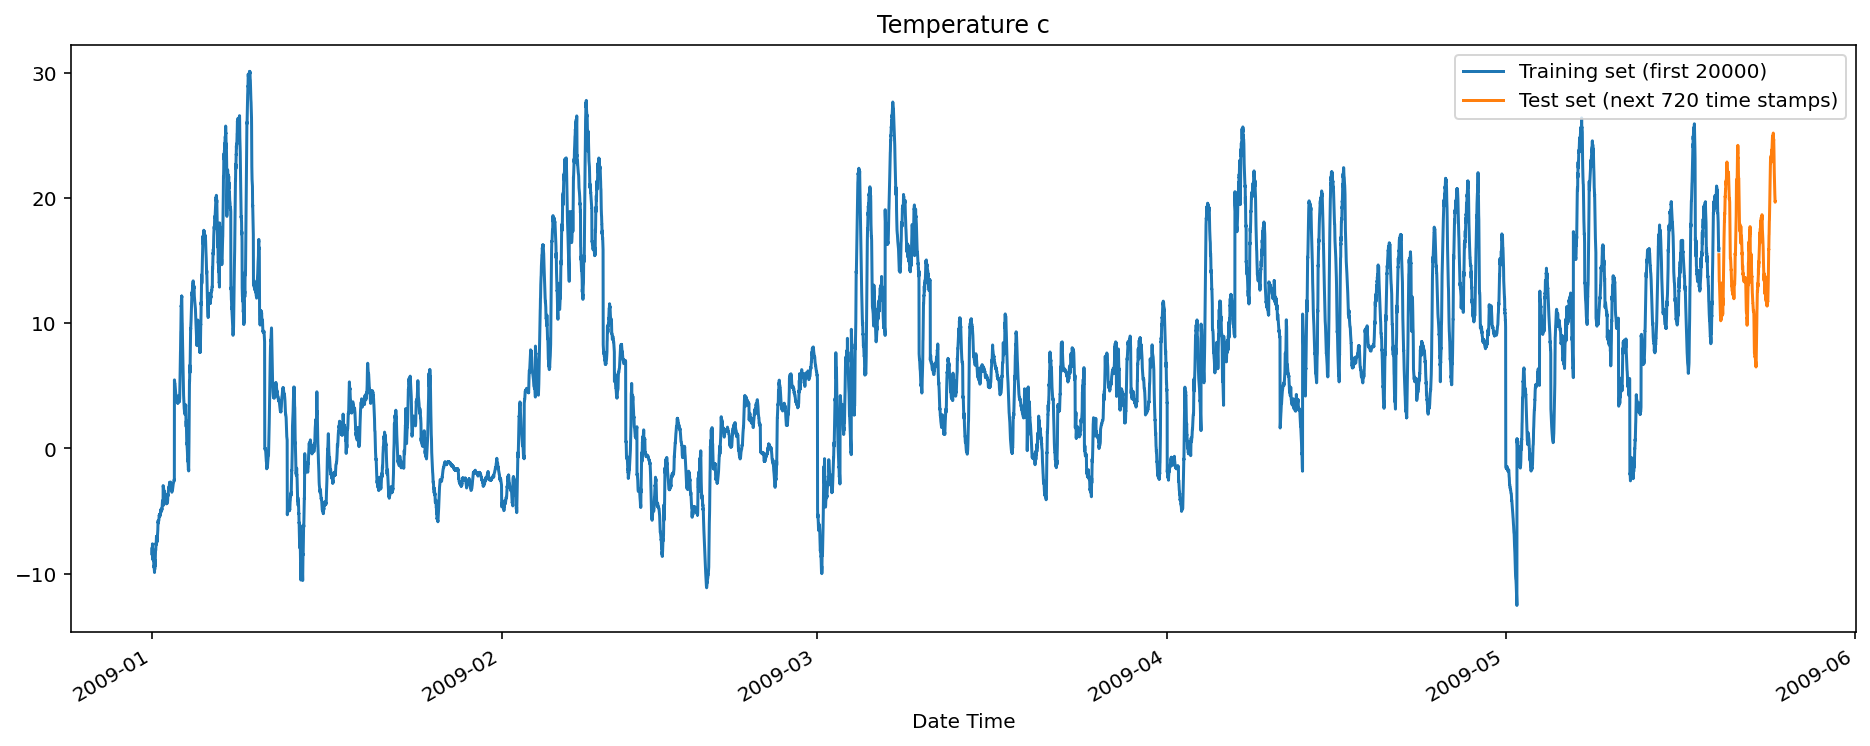

In [40]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
training_set.plot(figsize=(16,6),legend=True)
test_set.plot(figsize=(16,6),legend=True)
plt.legend(['Training set (first 20000)','Test set (next 720 time stamps)'])
plt.title('Temperature c')
plt.show()

In [63]:
# training_set.values
training_set_np = np.array(training_set)
# training_set_np
training_set_np = training_set_np.reshape(-1,1)
# training_set_np

In [61]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set_np)

In [62]:
training_set_scaled

array([[0.1059789 ],
       [0.0968347 ],
       [0.09449004],
       ...,
       [0.36764361],
       [0.37022274],
       [0.37139508]])

### Split the data

In [17]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [18]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [34]:
# df[date_time_key]
features

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944
...,...,...,...,...,...,...,...
420546,1.386902,-1.540264,-1.164797,-0.580316,-1.456301,1.876123,-0.968745
420547,1.369887,-1.459199,-1.132237,-0.534520,-1.452583,1.789472,-0.660963
420548,1.356518,-1.437195,-1.123121,-0.511622,-1.460020,1.763770,-0.700254
420549,1.355303,-1.561109,-1.172611,-0.571990,-1.482333,1.890320,-0.431764


In [42]:
# check out the last data row
features.loc[420550]

0    1.356518
1   -1.629436
2   -1.197357
3   -0.617785
4   -1.474895
5    1.959347
6   -0.602026
Name: 420550, dtype: float64

In [43]:
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


### Normalizing data

In [38]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [44]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [65]:
train_data.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [55]:
start = past + future
end = start + train_split
print('start = ', start)
print('end = ', end)
print('train_split = ', train_split)
sequence_length = int(past / step)
print('sequence_length = ', sequence_length)

start =  792
end =  301485
train_split =  300693
sequence_length =  120


### Find out the temprature for next 72 hours

In [56]:
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

In [61]:
print('type = ', type(x_train))
print("len of ", len(x_train))
x_train

type =  <class 'numpy.ndarray'>
len of  300693


array([[ 0.95545114, -2.00002   , -1.31978162, ..., -1.50092673,
         2.23765845, -0.73299722],
       [ 0.96152792, -2.04518494, -1.33280552, ..., -1.51952063,
         2.28783773, -0.93600233],
       [ 0.9566665 , -2.0567657 , -1.3354103 , ..., -1.52323941,
         2.29860792, -1.28307559],
       ...,
       [-0.11163086,  0.90211719,  0.78097422, ...,  1.39228456,
        -0.92045437, -0.79193419],
       [-0.11770764,  0.89632681,  0.77185748, ...,  1.38856578,
        -0.91653794, -0.79193419],
       [-0.11041551,  0.8639007 ,  0.72757621, ...,  1.39600334,
        -0.88740948, -0.8312255 ]])

In [64]:
print('type = ', type(y_train))
print("size = ", y_train.size)
y_train.head()

type =  <class 'pandas.core.frame.DataFrame'>
size =  300693


,1
792,-2.745821
793,-2.701814
794,-2.641594
795,-2.597587
796,-2.509573


### Preprocessing data 

In [66]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                                                x_train,
                                                                y_train,
                                                                sequence_length=sequence_length,
                                                                sampling_rate=step,
                                                                batch_size=batch_size,
                                                                )

2021-10-10 18:57:03.895577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(x_val,
                                                                y_val,
                                                                sequence_length=sequence_length,
                                                                sampling_rate=step,
                                                                batch_size=batch_size,
                                                                )


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


2021-09-21 23:10:08.024935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Assemble keras model

In [22]:
inputs = keras.layers.Input(shape=(inputs.shape[1], 
                                   inputs.shape[2]))

lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="mse")

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [23]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, 
                                            patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
                                                    monitor="val_loss",
                                                    filepath=path_checkpoint,
                                                    verbose=1,
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                )

history = model.fit(
                    dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[es_callback, modelckpt_callback],
                )

Epoch 1/10
1172/1172 [==============================] - 80s 67ms/step - loss: 0.1796 - val_loss: 0.1558

Epoch 00001: val_loss improved from inf to 0.15577, saving model to model_checkpoint.h5
Epoch 2/10
1172/1172 [==============================] - 91s 78ms/step - loss: 0.1272 - val_loss: 0.1366

Epoch 00002: val_loss improved from 0.15577 to 0.13663, saving model to model_checkpoint.h5
Epoch 3/10
1172/1172 [==============================] - 77s 66ms/step - loss: 0.1145 - val_loss: 0.1462

Epoch 00003: val_loss did not improve from 0.13663
Epoch 4/10
1172/1172 [==============================] - 75s 64ms/step - loss: 0.1107 - val_loss: 0.1434

Epoch 00004: val_loss did not improve from 0.13663
Epoch 5/10
1172/1172 [==============================] - 74s 64ms/step - loss: 0.1089 - val_loss: 0.1460

Epoch 00005: val_loss did not improve from 0.13663
Epoch 6/10
1172/1172 [==============================] - 75s 64ms/step - loss: 0.1069 - val_loss: 0.1446

Epoch 00006: val_loss did not improve

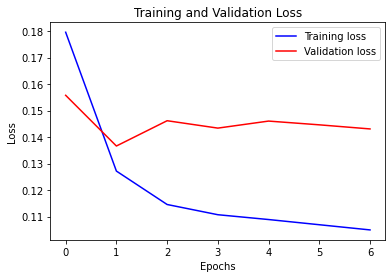

In [24]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

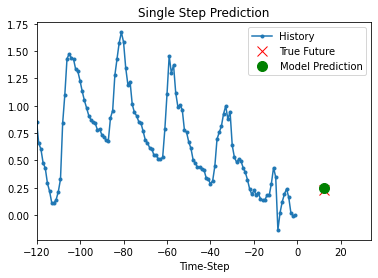

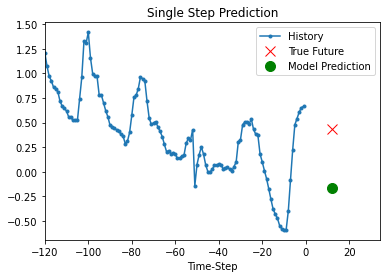

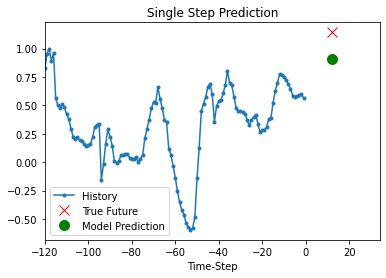

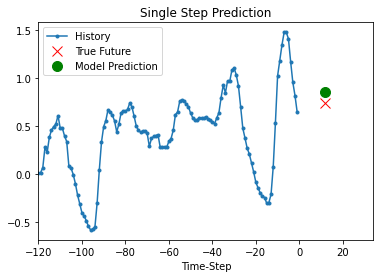

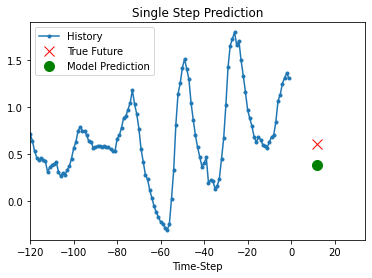

In [25]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )